## Setup

In [ ]:
!pip install scikit-learn==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


In [ ]:
import pandas as pd
import re
from dateutil import parser
import numpy as np
from datetime import datetime, timedelta
import math

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin


from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

print(uploaded)

In [ ]:
matches = pd.read_parquet('matches.parquet')
teams = pd.read_parquet('teams.parquet')
players = pd.read_parquet('players.parquet')

#### Ordenando por data e mudando o tipo do placar para inteiro

In [ ]:
matches['date'] = pd.to_datetime(matches['date'])

print(matches['date'].dtype)

datetime64[ns] datetime64[ns]


In [ ]:
matches.sort_values(by='date', inplace=True)
matches.reset_index(drop=True, inplace=True)
matches.index
matches[['A_score', 'B_score']] = matches[['A_score', 'B_score']].astype(int)

RangeIndex(start=0, stop=8187, step=1)

In [233]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 83 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   match_id                                 3157 non-null   int64         
 1   date                                     3157 non-null   datetime64[ns]
 2   best_of                                  3157 non-null   int64         
 3   tournament                               3157 non-null   object        
 4   tier                                     3157 non-null   object        
 5   team_A                                   3157 non-null   object        
 6   team_B                                   3157 non-null   object        
 7   A_score                                  3157 non-null   int64         
 8   B_score                                  3157 non-null   int64         
 9   team_A_player_1                          

### Glicko-2

In [ ]:

def single_match_rating(df, player, opponent, player_score, opponent_score, tau = 0.2, rec = True, kind = 'team'):
  """
  Implementação do algoritmo Glicko-2 em partidas únicas. Baseado no sistema Glicko-2 desenvolvido pelo Professor Mark E. Glickman.

    Args:
        player: DataFrame do jogador ou time
        opponent: DataFrame do jogador ou time oponente
        player_score: 0 para derrota, 1 para vitória
        opponent_score: 0 para derrota, 1 para vitória (foi colocado para teste em valores diferentes com base no tamanho da vitória, mas descartado)
        tau: constante float
        rec: parâmetro para ser colocado como False quando realizar uma função recursiva dentro da mesma (para atualizar os ratings do oponente)
        kind: "team" ou "player"
  """
  team_A = player.copy()
  team_B = opponent.copy()


  team_A['mi'] =  (team_A['rating'] - 1500)/173.7178
  team_A['fi'] = team_A['RD']/173.7178


  team_B["mi"] = (team_B['rating'] - 1500)/173.7178
  team_B["fi"] = team_B['RD']/173.7178

  fi = float(team_A['fi'].iloc[0])
  mi = float(team_A['mi'].iloc[0])
  sigma = float(team_A['sigma'].iloc[0])
  def g(fi):
    return 1/math.sqrt(1+3*(fi**2)/math.pi**2)
  def E(mij, fij, mi = mi):
    return 1/(1+math.exp(-g(fij)*(mi-mij)))
  def quantity(player_score, player, opponent):
    mij = float(team_B['mi'].iloc[0])
    fij = float(team_B['fi'].iloc[0])
    v = g(fij)**2 * E(mij, fij) * (1 - E(mij, fij))
    v **= -1
    delta = g(float(team_B['fi'].iloc[0]))*(player_score - E(float(team_B['mi'].iloc[0]), float(team_B['fi'].iloc[0])))
    delta *= v
    return v, delta
  v, delta = quantity(player_score, team_A, team_B)
  a = math.log(float(team_A['sigma'].iloc[0])**2)
  def f(x):
    return ((math.e**x *(delta**2 - fi**2 - v - math.e**x))/((2*(fi**2 + v + math.e**x))**2) - (x-a)/(tau**2))
  y = 0.000001
  A = a
  if delta**2 > fi**2 + v:
    B = math.log(delta**2 - fi**2 - v)
  else:
    k = 1
    while f(a - k*tau)< 0:
      k += 1
    B = a - k*tau
  fa, fb = f(A), f(B)
  while abs(B - A) > y:
    C = A + (A-B)*fa/(fb-fa)
    fc = f(C)
    if fc*fb <= 0:
      A, fa = B, fb
    else:
      fa = fa/2
    B, fb = C, fc
  sigmaL = math.e**(A/2)

  fio = math.sqrt(fi**2 + sigmaL**2)
  fiL = 1/math.sqrt(1/(fio**2) + 1/v)

  miL = mi + fiL**2 * g(float(team_B['fi'].iloc[0]))*(player_score - E(float(team_B['mi'].iloc[0]), float(team_B['fi'].iloc[0])))



  opp_ratings = [None, None, None]

  if rec == True:
    opp_ratings = single_match_rating(df, team_B, team_A, opponent_score, player_score, tau, False)


  ratings = {
      'rating': 173.7178 * miL + 1500,
      'RD': 173.7178 * fiL,
      'sigma': sigmaL
             }
  if kind == 'team':
    team_A_idx = df.index[df['name'] == team_A['name'].values[0]][0]
    team_B_idx = df.index[df['name'] == team_B['name'].values[0]][0]

    df.at[team_A_idx, "rating"] = ratings['rating']
    df.at[team_A_idx, "RD"] = ratings['RD']
    df.at[team_A_idx, "sigma"] = ratings['sigma']

    df.at[team_B_idx, "rating"] = opp_ratings[0]
    df.at[team_B_idx, "RD"] = opp_ratings[1]
    df.at[team_B_idx, "sigma"] = opp_ratings[2]
  else:
    player_idx = df.index[df['name'] == team_A['name'].values[0]][0]

    df.at[player_idx, "rating"] = ratings['rating']
    df.at[player_idx, "RD"] = ratings['RD']
    df.at[player_idx, "sigma"] = ratings['sigma']



  return [ratings['rating'],ratings['RD'],ratings['sigma'], opp_ratings[0], opp_ratings[1], opp_ratings[2]]


## Modelo matches

#### Retirando dados duplicados

In [ ]:
matches.drop_duplicates(subset='match_id', keep='first', inplace=True)

### Dividindo por ano

In [ ]:
# partidas 2022 ~ 2024
matches.reset_index(drop=True, inplace=True)

# partidas 2023
X_23 = matches.loc[(matches['date'] < '2024-01-01') &
             (matches['date'] > '2023-01-01')]
# partidas 2024
X_24 = matches.loc[(matches['date'] < '2025-01-01') &
             (matches['date'] > '2024-01-01')]
X_24 = X_24.copy()
X_24.sort_values(by='date', inplace=True)
X_24.reset_index(drop=True, inplace=True)

# partidas 2023+2024
X_2 = pd.concat([X_23, X_24])
X_2.sort_values(by='date', inplace=True)
X_2.reset_index(drop=True, inplace=True)

### Atualizando times conforme o ano

#### Transformer


In [ ]:
class CreatingTeams(BaseEstimator, TransformerMixin):
  def __init__(self, teams):
    self.teams = teams.copy()
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    self.new_teams = self.teams.copy()
    self.new_teams[['rating', 'RD', 'sigma']] = [None, 350, 0.06]
    teams_list = []
    for index, row in X.iterrows():
      for team in ['team_A', 'team_B']:
        team_name = row[team]
        if team_name not in teams_list:
          teams_list.append(team_name)
          team_idx = self.new_teams.loc[self.new_teams["name"] == team_name].index[0]
          match row['tier']:
            case 'S':
              self.new_teams.loc[team_idx, 'rating'] = 1500
            case 'A':
              self.new_teams.loc[team_idx, 'rating'] = 1000
            case 'B':
              self.new_teams.loc[team_idx, 'rating'] = 500
    self.new_teams.dropna(inplace=True)
    return self.new_teams

#### Executando

In [ ]:
transformer = CreatingTeams(teams)
teams_1 = transformer.fit_transform(matches)
teams_2 = transformer.fit_transform(X_2)
teams_24 = transformer.fit_transform(X_24)

### Aplicando glicko nos times

In [ ]:
def glicko_teams(teams, df):
  match_ratings_list = []
  matches = df.copy()
  dict_cols = {j: i for i, j in enumerate(matches.columns)}
  for row in matches.values:
      team_A = teams.loc[teams['name'] == row[dict_cols['team_A']]]
      team_B = teams.loc[teams['name'] == row[dict_cols['team_B']]]

      match_ratings_list.append([
          float(team_B['rating'].iloc[0]),
          float(team_B['RD'].iloc[0]),
          float(team_B['sigma'].iloc[0]),
          float(team_A['rating'].iloc[0]),
          float(team_A['RD'].iloc[0]),
          float(team_A['sigma'].iloc[0])
          ])

      team_A_score = ((int(row[dict_cols['A_score']])-int(row[dict_cols['B_score']]) + 3)/6)
      team_B_score = ((int(row[dict_cols['B_score']])-int(row[dict_cols['A_score']]) + 3)/6)

      match_ratings = single_match_rating(teams, team_A, team_B, team_A_score, team_B_score, tau=0.2, rec=True)

  mr_df = pd.DataFrame(match_ratings_list, columns=["team_B_rating", "team_B_RD", "team_B_sigma", "team_A_rating", "team_A_RD", "team_A_sigma"])

  matches[list(mr_df.columns)] = mr_df
  return matches


In [ ]:
matches = glicko_teams(teams_1, matches)
X_2 = glicko_teams(teams_2, X_2)
X_24 = glicko_teams(teams_24, X_24)

##### vendo top 10

In [ ]:
teams_24.sort_values(by='rating', ascending=False).head(10)

,name,players,rating,RD,sigma
27,Gen.G Esports,"[Meteor, T3xture, Lakia, Munchkin, Karon]",1676.116114,83.166689,0.059996
188,EDward Gaming,"[Haodong, CHICHOO, Nobody, ZmjjKK, Smoggy]",1653.618074,95.920166,0.059998
205,Team Heretics,"[Boo, Benjyfishy, RieNs, Wo0t, PaTiTek]",1652.045091,84.257547,0.059997
7,FunPlus Phoenix,"[AAAAY, BerLIN, Lysoar, Autumn, Life]",1642.933844,97.028153,0.059998
113,Paper Rex,"[Mindfreak, F0rsakeN, D4v41, Something, Jinggg]",1639.92528,90.422113,0.059998
456,UCAM Esports Club,"[Quick, Famsii, Flickless, OLIZERA, Azury]",1616.760513,241.527132,0.060003
59,DRX,"[Stax, BuZz, MaKo, Foxy9, BeYN]",1611.149808,127.457849,0.059999
11,Natus Vincere,"[ANGE1, SUYGETSU, Shao, Zyppan, Ardiis]",1577.839151,131.891221,0.059999
3,Fnatic,"[Boaster, Derke, Alfajer, Leo, Chronicle]",1565.063203,100.284444,0.059998
292,Karmine Corp,"[Shin, Magnum, Marteen, N4RRATE, Tomaszy]",1563.241094,100.935040,0.059998


### Atualizando jogadores conforme o ano

#### Transformer

In [ ]:
class CreatingPlayers(BaseEstimator, TransformerMixin):
  def __init__(self, players):
    self.players = players.copy()
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    self.new_players = self.players.copy()
    self.new_players[['rating', 'RD', 'sigma']] = [None, 350, 0.06]
    players_list = []
    for index, row in X.iterrows():
      for player in [f'team_A_player_{i}' for i in range(1,6)]+[f'team_B_player_{i}' for i in range(1,6)]:
        player_name = row[player]
        if player_name not in players_list:
          players_list.append(player_name)
          player_idx = self.new_players.loc[self.new_players["name"] == player_name].index[0]
          match row['tier']:
            case 'S':
              self.new_players.loc[player_idx, 'rating'] = 1500
            case 'A':
              self.new_players.loc[player_idx, 'rating'] = 1000
            case 'B':
              self.new_players.loc[player_idx, 'rating'] = 500
    self.new_players.dropna(inplace=True)
    return self.new_players

#### Executando transformer

In [ ]:
transformer = CreatingPlayers(players)
players_1 = transformer.fit_transform(matches)
players_2 = transformer.fit_transform(X_2)
players_24 = transformer.fit_transform(X_24)

### Aplicando glicko nos players

In [ ]:
def glicko_players(players, df):
  match_ratings_list = []
  matches = df.copy()
  dict_cols = {j: i for i, j in enumerate(matches.columns)}

  for row in matches.values:

      players_team_A = []
      players_team_B = []

      for j in range(1,6):
          players_team_A.append(players.loc[players['name'] == row[dict_cols[f'team_A_player_{j}']]][['rating','RD','sigma','name']])

          players_team_B.append(players.loc[players['name'] == row[dict_cols[f'team_B_player_{j}']]][['rating','RD','sigma','name']])

      players_combined_A = pd.concat(players_team_A)
      players_combined_B = pd.concat(players_team_B)

      players_A = players_combined_A.drop('name', axis=1).mean()

      players_B = players_combined_B.drop('name', axis=1).mean()

      team_A_score = ((int(row[dict_cols['A_score']])-int(row[dict_cols['B_score']]) + 3)/6)
      team_B_score = ((int(row[dict_cols['B_score']])-int(row[dict_cols['A_score']]) + 3)/6)

      match_rating = {}
      for k in range(5):
          match_rating[f'team_A_player_{k+1}_rating'] = float(players_team_A[k]['rating'].iloc[0])
          match_rating[f'team_A_player_{k+1}_RD'] = float(players_team_A[k]['RD'].iloc[0])
          match_rating[f'team_A_player_{k+1}_sigma'] = float(players_team_A[k]['sigma'].iloc[0])

          match_rating[f'team_B_player_{k+1}_rating'] = float(players_team_B[k]['rating'].iloc[0])
          match_rating[f'team_B_player_{k+1}_RD'] = float(players_team_B[k]['RD'].iloc[0])
          match_rating[f'team_B_player_{k+1}_sigma'] = float(players_team_B[k]['sigma'].iloc[0])

          rating_list_A = single_match_rating(
              players,
              pd.DataFrame(players_team_A[k]),
              pd.DataFrame(players_B).T,
              team_A_score,
              team_B_score,
              tau=0.2, rec=False, kind='player')

          rating_list_B = single_match_rating(
              players,
              pd.DataFrame(players_team_B[k]),
              pd.DataFrame(players_A).T,
              team_B_score,
              team_A_score,
              tau=0.2, rec=False, kind='player')

      match_ratings_list.append(match_rating)


  mr_df = pd.DataFrame(match_ratings_list)
  matches[list(mr_df.columns)] = mr_df
  return matches

In [ ]:
matches = glicko_players(players_1, matches)
X_2 = glicko_players(players_2, X_2)
X_24 = glicko_players(players_24, X_24)

##### vendo top players

In [ ]:
players_2.sort_values(by='rating', ascending=False).head(10)

,name,country,team,rating,RD,sigma
1553,OLIZERA,Portugal,UCAM Esports Club,1796.375024,237.384552,0.060003
5,Chronicle,Russia,Fnatic,1622.868147,76.806788,0.059997
16,Boaster,United Kingdom,Fnatic,1622.868147,76.806788,0.059997
20,Derke,Finland,Fnatic,1622.868147,76.806788,0.059997
717,Alfajer,Turkey,Fnatic,1622.868147,76.806788,0.059997
1384,Demon1,United States,NRG,1622.255596,75.855334,0.059996
561,Jinggg,Singapore,Paper Rex,1619.616732,79.818287,0.059996
105,Jawgemo,Cambodia,Evil Geniuses,1619.616404,74.628380,0.059996
74,Ethan,United States,NRG,1618.836801,74.855004,0.059996
1095,Famsii,Finland,UCAM Esports Club,1612.451486,232.289828,0.060003


### RD feature


In [ ]:
class AddRDFearure(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        RD_class = np.zeros(len(X))
        for i in range(len(X)):
          AR = X.iloc[i]['team_A_rating']
          BR = X.iloc[i]['team_B_rating']
          ARD = X.iloc[i]['team_A_RD']
          BRD = X.iloc[i]['team_B_RD']
          if (AR + ARD) > BR and (BR + BRD) > AR:
            RD_class[i] = 1
          elif (AR + ARD) > (BR - BRD) and (BR + BRD) > (AR - ARD):
            RD_class[i] = 2
          else:
            RD_class[i] = 3

          if AR > BR:
            RD_class[i] *= -1

        X['RD_class'] = RD_class
        return X

### Estatísticas por torneio

In [ ]:
class AddChampionshipStats(BaseEstimator, TransformerMixin):
  """
  % win geral
  % win por 2 a 0/ 3 a 0
  % win dropando pelo menos 1 mapa
  % lose ganhando pelo menos 1 mapa
  % lose por 2 a 0 / 3 a 0
  diferença rating começo e final do campeonato
  """
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    features_list = []
    cols = {j: i for i, j in enumerate(X.columns)}

    for row in X.values:
      wr_0_A, big_win_0_A, small_win_0_A, big_lose_0_A, small_lose_0_A, delta_rating_0_A = 0.5, 0.25, 0.25, 0.25, 0.25, 0
      wr_1_A, big_win_1_A, small_win_1_A, big_lose_1_A, small_lose_1_A, delta_rating_1_A = 0.5, 0.25, 0.25, 0.25, 0.25, 0
      wr_0_B, big_win_0_B, small_win_0_B, big_lose_0_B, small_lose_0_B, delta_rating_0_B = 0.5, 0.25, 0.25, 0.25, 0.25, 0
      wr_1_B, big_win_1_B, small_win_1_B, big_lose_1_B, small_lose_1_B, delta_rating_1_B = 0.5, 0.25, 0.25, 0.25, 0.25, 0

      tournaments_A = X.loc[(X['date'] < row[cols['date']])       &
                          ((X['team_A'] == row[cols['team_A']])  |
                          (X['team_B'] == row[cols['team_A']]))
                          ]['tournament']
      if len(tournaments_A) > 0:
        tournament_0_A = tournaments_A.iloc[-1]
        tournaments_1_A = tournaments_A.loc[tournaments_A != tournament_0_A]

        wr_0_A, big_win_0_A, small_win_0_A, big_lose_0_A, small_lose_0_A, delta_rating_0_A = self.__get_stats(tournament_0_A, X, row, cols, "team_A")

        if len(tournaments_1_A) > 0:
          tournament_1_A = tournaments_1_A.iloc[-1]
          wr_1_A, big_win_1_A, small_win_1_A, big_lose_1_A, small_lose_1_A, delta_rating_1_A = self.__get_stats(tournament_1_A, X, row, cols, "team_A")

      tournaments_B = X.loc[(X['date'] < row[cols['date']])       &
                          ((X['team_A'] == row[cols['team_B']])  |
                          (X['team_B'] == row[cols['team_B']]))
                          ]['tournament']

      if len(tournaments_B) > 0:
        tournament_0_B = tournaments_B.iloc[-1]
        tournaments_1_B = tournaments_B.loc[tournaments_B != tournament_0_B]
        wr_0_B, big_win_0_B, small_win_0_B, big_lose_0_B, small_lose_0_B, delta_rating_0_B = self.__get_stats(tournament_0_B, X, row, cols, "team_B")

        if len(tournaments_1_B) > 0:
          tournament_1_B = tournaments_1_B.iloc[-1]
          wr_1_B, big_win_1_B, small_win_1_B, big_lose_1_B, small_lose_1_B, delta_rating_1_B = self.__get_stats(tournament_1_B, X, row, cols, "team_B")

      features_list.append([wr_0_A, big_win_0_A,
                           small_win_0_A, big_lose_0_A,
                           small_lose_0_A, delta_rating_0_A,
                           wr_1_A, big_win_1_A,
                           small_win_1_A, big_lose_1_A,
                           small_lose_1_A, delta_rating_1_A,
                           wr_0_B, big_win_0_B,
                           small_win_0_B, big_lose_0_B,
                           small_lose_0_B, delta_rating_0_B,
                           wr_1_B, big_win_1_B,
                           small_win_1_B, big_lose_1_B,
                           small_lose_1_B, delta_rating_1_B]
                           )

    features_df = pd.DataFrame(features_list, columns=["team_A_tournament_wr",
                                                      "team_A_tournament_big_win_ratio",
                                                      "team_A_tournament_small_win_ratio",
                                                      "team_A_tournament_big_lose_ratio",
                                                      "team_A_tournament_small_lose_ratio",
                                                      "team_A_tournament_delta_rating",
                                                      "team_A_last_tournament_wr",
                                                      "team_A_last_tournament_big_win_ratio",
                                                      "team_A_last_tournament_small_win_ratio",
                                                      "team_A_last_tournament_big_lose_ratio",
                                                      "team_A_last_tournament_small_lose_ratio",
                                                      "team_A_last_tournament_delta_rating",
                                                      "team_B_tournament_wr",
                                                      "team_B_tournament_big_win_ratio",
                                                      "team_B_tournament_small_win_ratio",
                                                      "team_B_tournament_big_lose_ratio",
                                                      "team_B_tournament_small_lose_ratio",
                                                      "team_B_tournament_delta_rating",
                                                      "team_B_last_tournament_wr",
                                                      "team_B_last_tournament_big_win_ratio",
                                                      "team_B_last_tournament_small_win_ratio",
                                                      "team_B_last_tournament_big_lose_ratio",
                                                      "team_B_last_tournament_small_lose_ratio",
                                                      "team_B_last_tournament_delta_rating",])
    X[features_df.columns] = features_df
    return X

  def __get_stats(self, tournament, X, row, cols, team):
    X_t = X.loc[((X['date'] < row[cols['date']])       &
                ((X['team_A'] == row[cols[team]])  |
                (X['team_B'] == row[cols[team]]))) &
                  (X['tournament'] == tournament)
                ]
    X_t = X_t.copy()
    X_t['win'] = np.where(X_t['team_A'] == row[cols[team]], 1 - X_t['win'], X_t['win'])
    X_t['rating'] = np.where(X_t['team_A'] == row[cols[team]], X_t['team_A_rating'], X_t['team_B_rating'])

    wr = X_t['win'].mean()
    if len(X_t) == 0:
      print(tournament, row[cols[team]])
    big_win = len(X_t.loc[(X_t['win'] == 1) &
                      ((X_t['A_score'] == 0)      |
                        (X_t['B_score'] == 0))
                      ]) / len(X_t)
    small_win = wr - big_win

    big_lose = len(X_t.loc[(X_t['win'] == 0) &
                      ((X_t['A_score'] == 0)      |
                        (X_t['B_score'] == 0))
                      ]) / len(X_t)

    small_lose = 1 - wr - big_lose

    delta_rating = X_t.iloc[-1]['rating'] - X_t.iloc[0]['rating']
    return wr, big_win, small_win, big_lose, small_lose, delta_rating


### Pegando rating diff

#### Team

In [ ]:
class AddDiff(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rating_diff = X['team_B_rating'] - X['team_A_rating']

        team_B_avg_rating = X[['team_B_player_1_rating',
                             'team_B_player_2_rating',
                             'team_B_player_3_rating',
                             'team_B_player_4_rating',
                             'team_B_player_5_rating']].mean(axis=1)

        team_A_avg_rating = X[['team_A_player_1_rating',
                                'team_A_player_2_rating',
                                'team_A_player_3_rating',
                                'team_A_player_4_rating',
                                'team_A_player_5_rating']].mean(axis=1)

        player_rating_diff = team_B_avg_rating - team_A_avg_rating

        X[['rating_diff', 'player_rating_diff']] = np.column_stack((rating_diff, player_rating_diff))
        return X

### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
        ('AddRDFearure', AddRDFearure()),
        ('AddChampionshipStats', AddChampionshipStats()),
        ('AddDiff', AddDiff()),
        ])

In [ ]:
matches = pipeline.fit_transform(matches)
X_2 = pipeline.fit_transform(X_2)
X_24 = pipeline.fit_transform(X_24)

## **Gráficos**

#### Accuracy

In [ ]:
def get_accuracy(matches):
  dtype = np.dtype([('glicko_accuracy', float), ('date_time', object)])

  glicko_accuracy = np.zeros((len(matches), ), dtype=dtype)
  for i in range(1, len(matches)+ 1):
    initial = 0 #if i < 500 else i-500
    glicko_accuracy[i-1]['glicko_accuracy'] = (((matches.iloc[initial:i]['team_B_rating'] - matches.iloc[initial:i]['team_A_rating']) > 0) == matches.iloc[initial:i]['win']).mean()
    glicko_accuracy[i-1]['date_time'] = matches.iloc[i-1]['date']
  return glicko_accuracy

In [ ]:
glicko_accuracy = get_accuracy(matches) # todas as partidas
glicko_accuracy_2 = get_accuracy(X_2) # partidas 2023 + 2024
glicko_accuracy_24 = get_accuracy(X_24) # partidas 2024
print(f"2022 ~ 2024: {glicko_accuracy[-1][0]}")
print(f"2023 ~ 2024: {glicko_accuracy_2[-1][0]}")
print(f"2024: {glicko_accuracy_24[-1][0]}")

2022 ~ 2024: 0.5964523281596452
2023 ~ 2024: 0.6052855924978687
2024: 0.5898950131233596


#### ACC relativa ao RD

In [ ]:
def get_acc_RD_0(matches): # Partidas em que os times estão dentro do mesmo range de rating
  accuracy_out_of_range_list = []
  for i in range(len(matches)):
    AR = matches.iloc[i]['team_A_rating']
    BR = matches.iloc[i]['team_B_rating']
    ARD = matches.iloc[i]['team_A_RD']
    BRD = matches.iloc[i]['team_B_RD']
    if ((AR + ARD) > (BR)) and ((BR + BRD) > (AR)):
      accuracy_out_of_range_list.append((AR < BR) == matches.iloc[i]['win'])
  accuracy_out_of_range = np.array((accuracy_out_of_range_list))
  return accuracy_out_of_range.mean(), len(accuracy_out_of_range)/len(matches)


In [ ]:
acc_RD_0 = get_acc_RD_0(matches) # todas as partidas
acc_RD_0_2 = get_acc_RD_0(X_2) # partidas 2023 + 2024
acc_RD_0_24 = get_acc_RD_0(X_24) # partidas 2024

acc_RD_0, acc_RD_0_2, acc_RD_0_24  # (acerto, porcentagem de partidas)

((0.5575650639611822, 0.718086791257523),
 (0.5575275397796817, 0.6965046888320545),
 (0.5609756097560976, 0.8070866141732284))

In [ ]:
def get_acc_RD_1(matches): # Partidas em que os range de rating dos times se encontram mas um não está inserido no range do outro
  accuracy_out_of_range_list = []
  for i in range(len(matches)):
    AR = matches.iloc[i]['team_A_rating']
    BR = matches.iloc[i]['team_B_rating']
    ARD = matches.iloc[i]['team_A_RD']
    BRD = matches.iloc[i]['team_B_RD']
    if ((AR + ARD) > (BR)) and ((BR + BRD) > (AR)):
      continue
    if ((AR + ARD) > (BR - BRD)) and ((BR + BRD) > (AR - ARD)):
      accuracy_out_of_range_list.append((AR < BR) == matches.iloc[i]['win'])
  accuracy_out_of_range = np.array((accuracy_out_of_range_list))
  return accuracy_out_of_range.mean(), len(accuracy_out_of_range)/len(matches)

In [ ]:
acc_RD_1 = get_acc_RD_1(matches) # todas as partidas
acc_RD_1_2 = get_acc_RD_1(X_2) # partidas 2023 + 2024
acc_RD_1_24 = get_acc_RD_1(X_24) # partidas 2024

acc_RD_1, acc_RD_1_2, acc_RD_1_24  # (acerto, porcentagem de partidas)

((0.6643835616438356, 0.18498574596135572),
 (0.6894273127753304, 0.19352088661551578),
 (0.7104072398190046, 0.14501312335958005))

In [ ]:
def get_acc_RD_2(matches): # Partidas em que os os ranges do rating não se encontram
  accuracy_out_of_long_range_list = []
  for i in range(len(matches)):
    AR = matches.iloc[i]['team_A_rating']
    BR = matches.iloc[i]['team_B_rating']
    ARD = matches.iloc[i]['team_A_RD']
    BRD = matches.iloc[i]['team_B_RD']
    if ((AR + ARD) > (BR - BRD)) and ((BR + BRD) > (AR - ARD)):
      continue
    accuracy_out_of_long_range_list.append((AR < BR) == matches.iloc[i]['win'])
  accuracy_out_of_long_range = np.array((accuracy_out_of_long_range_list))
  return accuracy_out_of_long_range.mean(), len(accuracy_out_of_long_range)/len(matches)

In [ ]:
acc_RD_2 = get_acc_RD_2(matches) # todas as partidas
acc_RD_2_2 = get_acc_RD_2(X_2) # partidas 2023 + 2024
acc_RD_2_24 = get_acc_RD_2(X_24) # partidas 2024

acc_RD_2, acc_RD_2_2, acc_RD_2_24  # (acerto, porcentagem de partidas)

((0.7549019607843137, 0.09692746278112131),
 (0.7596899224806202, 0.10997442455242967),
 (0.7123287671232876, 0.047900262467191604))

#### Gráfico por mês

In [ ]:
def monthly_graph(matches):

  matches_copy = matches.copy()
  matches_copy.set_index('date', inplace=True)

  # Calcule a média dos valores de 'data' por mês
  monthly_data = matches_copy.resample('M').apply(lambda x: ((x['team_A_rating'] < x['team_B_rating']) == x['win']).mean())
  monthly_counts = matches_copy.resample('M').size()

  # Plotando os dados
  plt.figure(figsize=(10, 6))
  plt.plot(monthly_data.index, monthly_data, marker='o', linestyle='-', zorder=1)
  plt.scatter(monthly_data.index, monthly_data, s=monthly_counts, alpha=1, c='darkorange', zorder=2)
  plt.title('Glicko accuracy by month')
  plt.xlabel('Month')
  plt.ylabel('Glicko accuracy')
  plt.grid(True)

  # Adicionando anotações com o número do mês acima de cada ponto
  for i, (date, value) in enumerate(monthly_data.items()):
      plt.annotate(date.strftime('%m'),  # Obtendo o número do mês como string
                  (date, value),         # Posição do ponto (x, y)
                  textcoords="offset points",  # Utilizando coordenadas de offset
                  xytext=(0, 10),        # Offset em relação ao ponto (x, y) em pixels
                  ha='center',
                  fontsize=9,
                  c='red'
                  )

  plt.show()

##### 2022

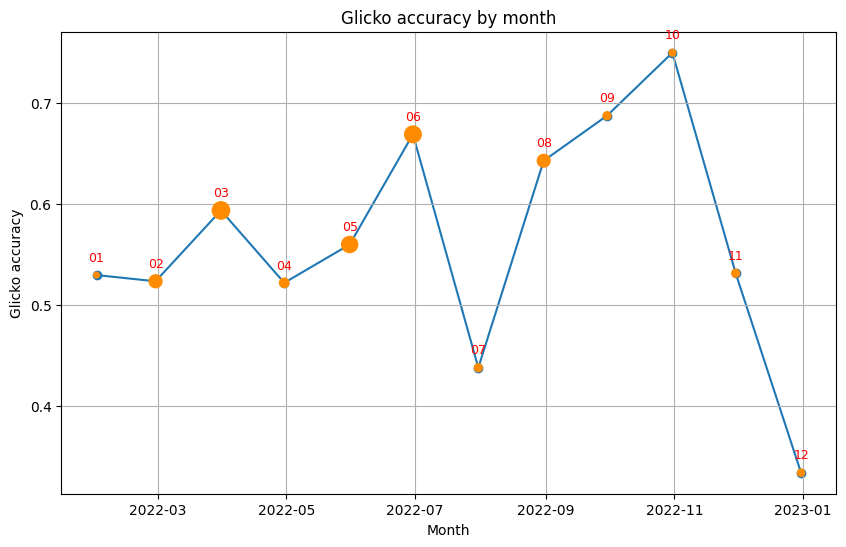

In [ ]:
matches_22 = matches.loc[(matches['date'] > '2022-01-01') &
                         (matches['date'] < '2023-01-01')]
matches_23 = matches.loc[(matches['date'] > '2023-01-01') &
                         (matches['date'] < '2024-01-01')]
matches_24 = matches.loc[(matches['date'] > '2024-01-01') &
                         (matches['date'] < '2025-01-01')]
X_2_23 = X_2.loc[(X_2['date'] > '2023-01-01') &
                 (X_2['date'] < '2024-01-01')]
X_2_24 = X_2.loc[(X_2['date'] > '2024-01-01') &
                 (X_2['date'] < '2025-01-01')]

monthly_graph(matches_22)

##### 2023

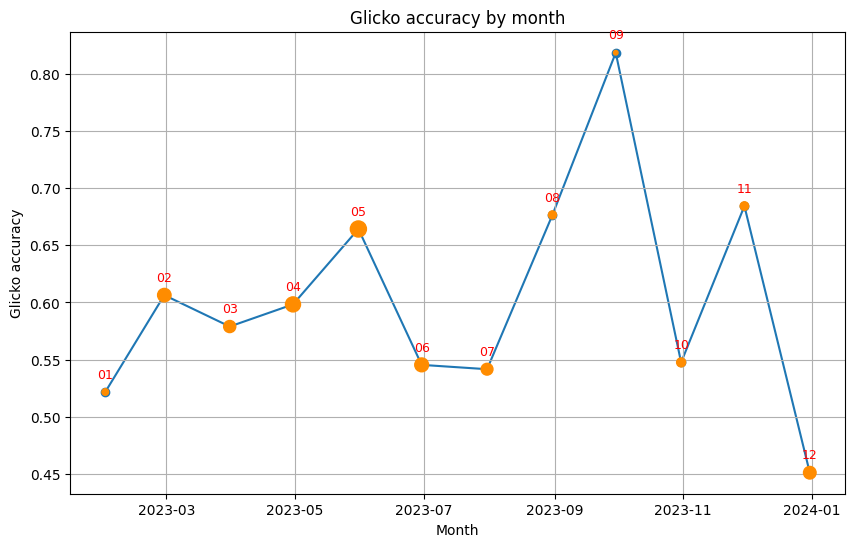

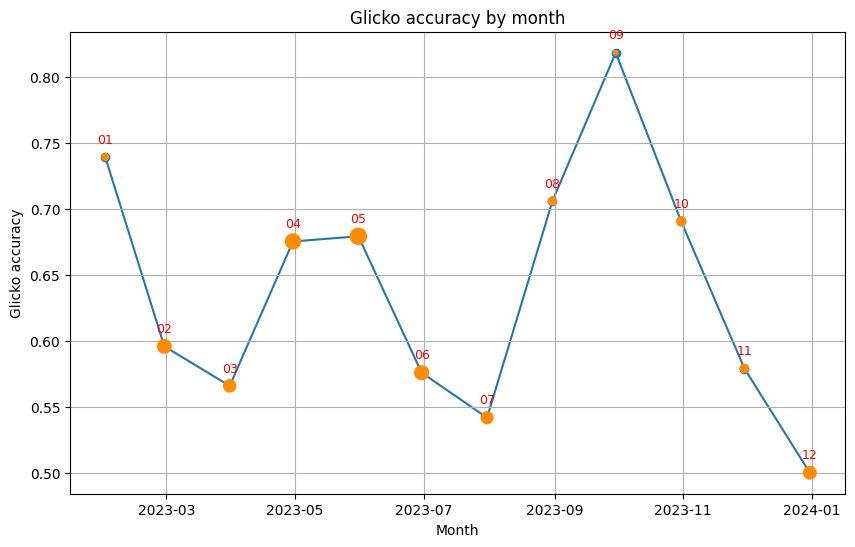

In [ ]:
monthly_graph(matches_23)
monthly_graph(X_2_23)

##### 2024

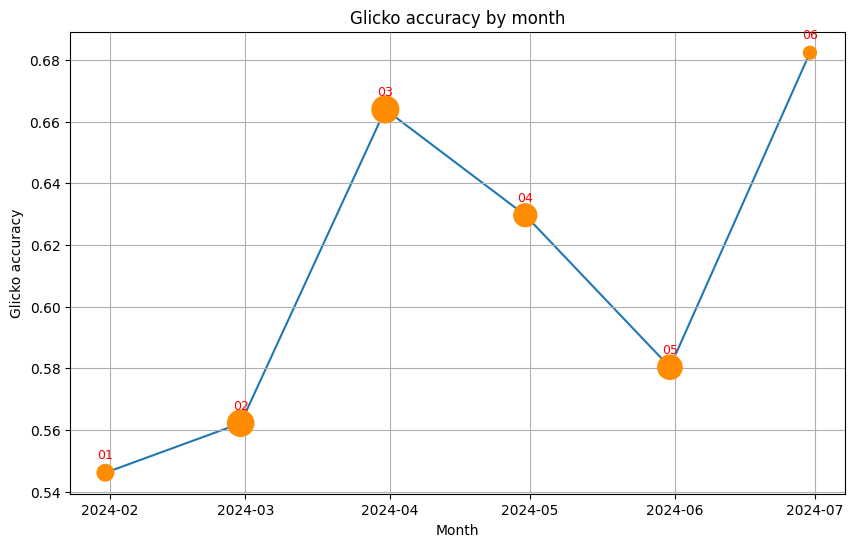

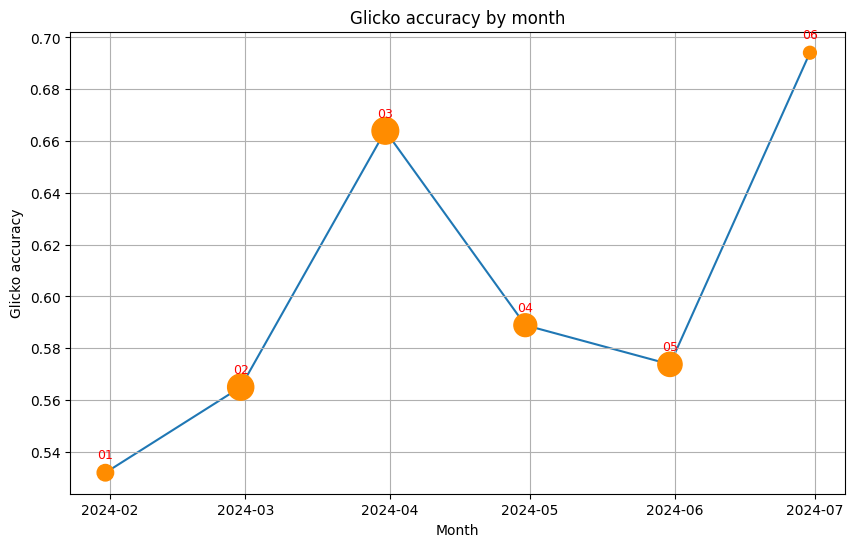

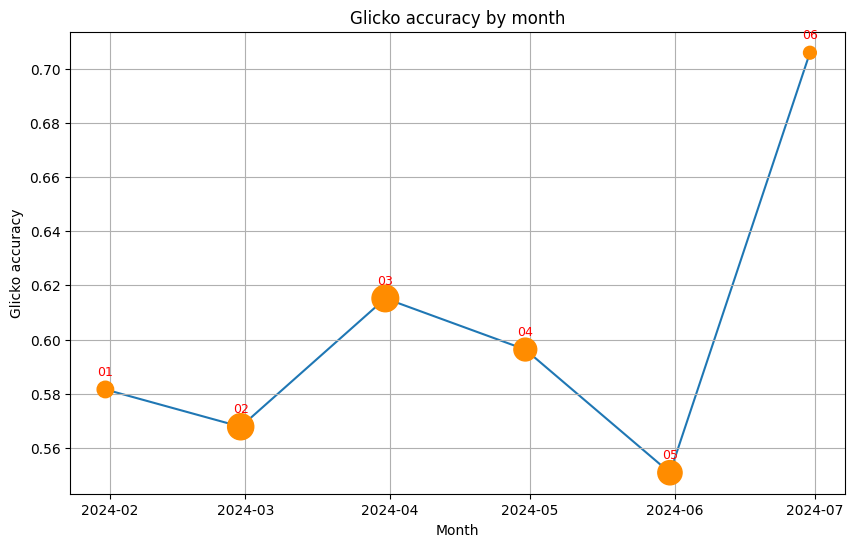

In [ ]:
monthly_graph(matches_24)
monthly_graph(X_2_24)
monthly_graph(X_24)

#### Gráfico com todas por data

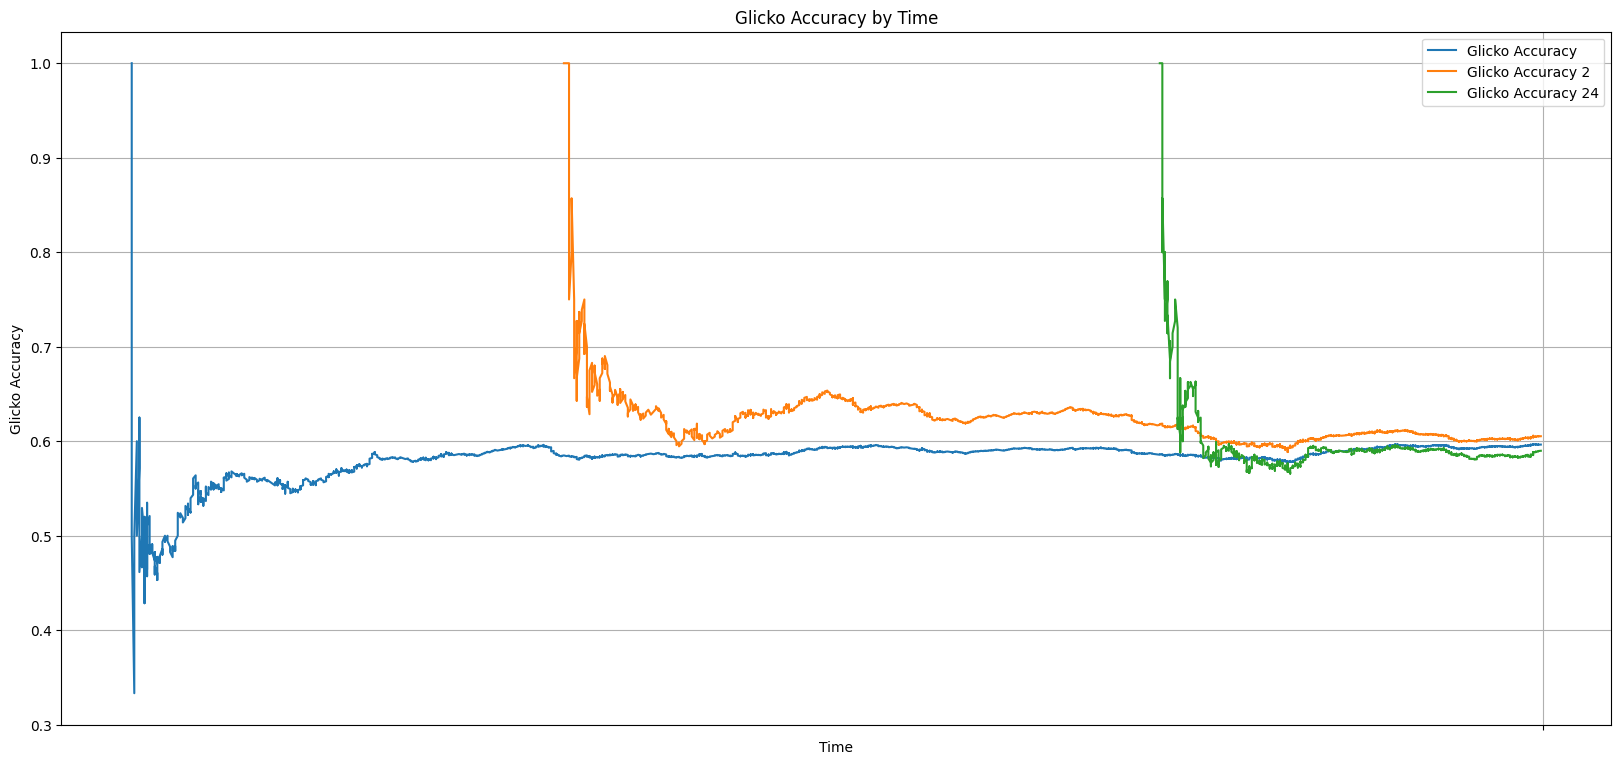

In [ ]:
dates = [str(date) for date in glicko_accuracy['date_time']]
dates_2 = [str(date) for date in glicko_accuracy_2['date_time']]
dates_24 = [str(date) for date in glicko_accuracy_24['date_time']]

plt.figure(figsize=(20, 9))
plt.plot(dates, glicko_accuracy['glicko_accuracy'], label='Glicko Accuracy')
plt.plot(dates_2, glicko_accuracy_2['glicko_accuracy'], label='Glicko Accuracy 2')
plt.plot(dates_24, glicko_accuracy_24['glicko_accuracy'], label='Glicko Accuracy 24')

plt.title('Glicko Accuracy by Time')
plt.xlabel('Time')
plt.ylabel('Glicko Accuracy')
plt.xticks([''])
plt.grid(True)
plt.legend()
plt.show()

#### Gráficos todos por ano

##### 2022

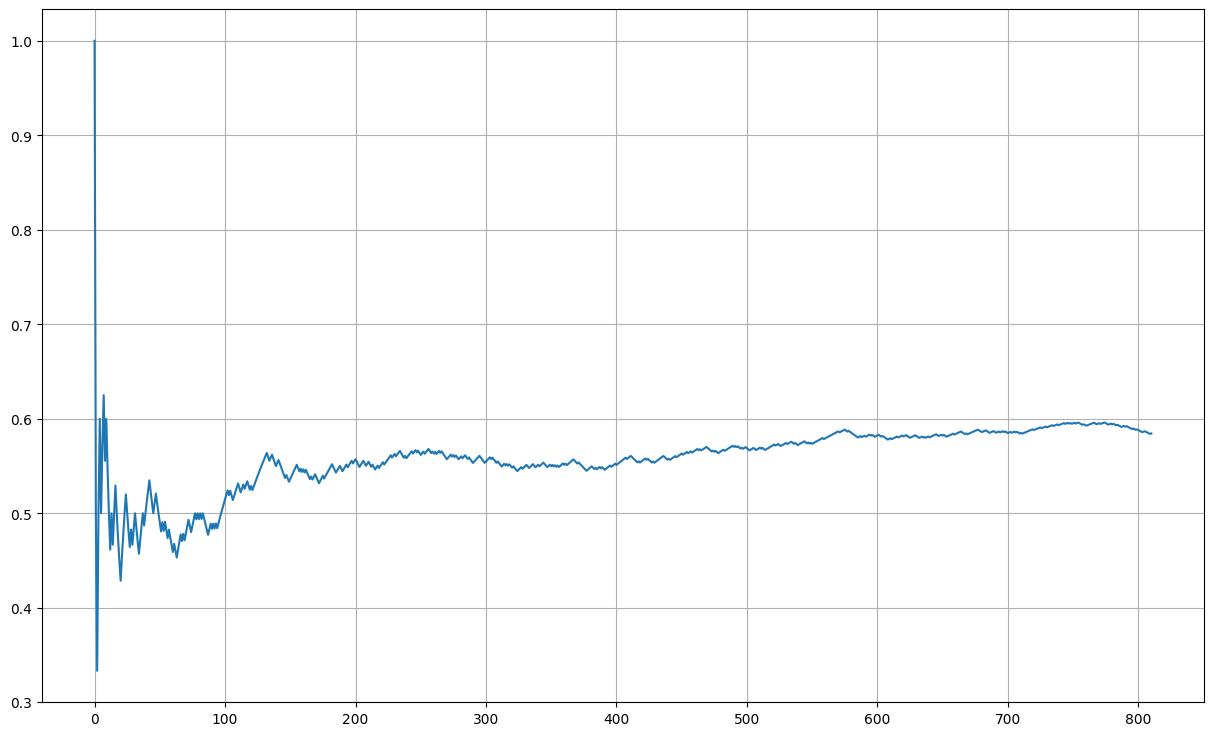

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(glicko_accuracy[glicko_accuracy['date_time'] < pd.Timestamp('2023-01-01')]['glicko_accuracy'], label='Glicko Accuracy')
plt.grid(True)

##### 2023

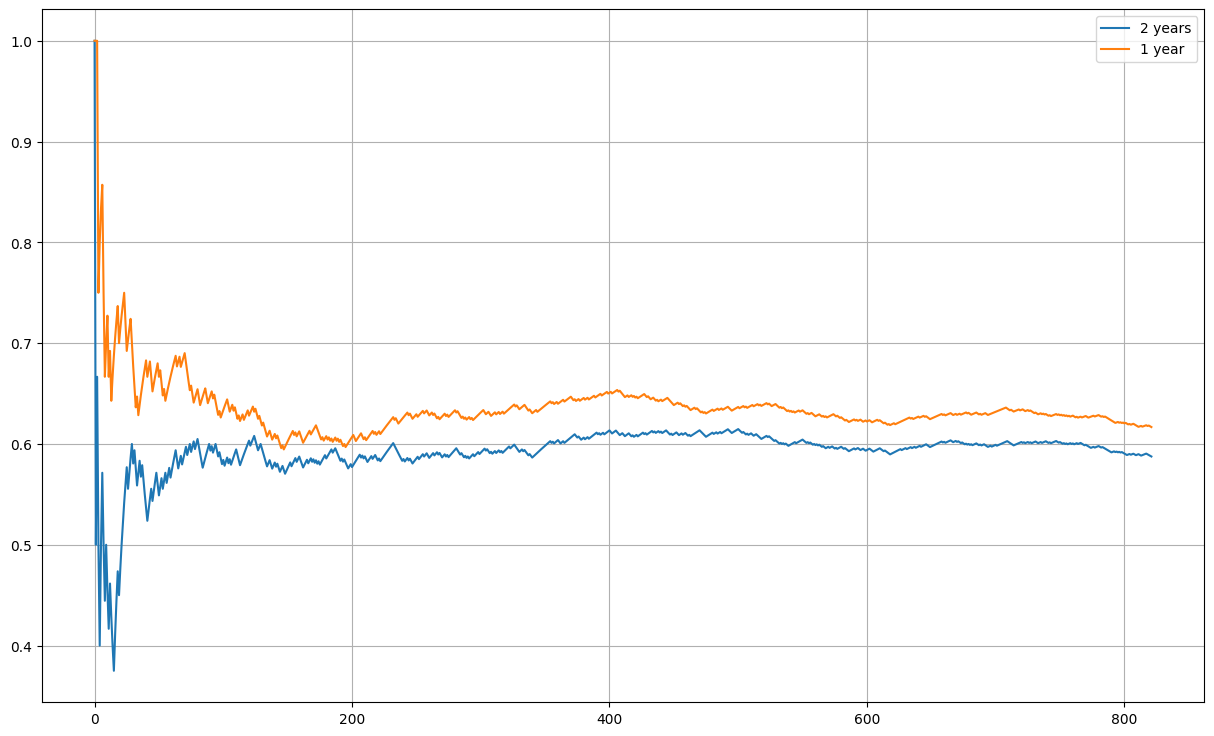

In [ ]:
acc_22_23 = get_accuracy(matches_23)

plt.figure(figsize=(15, 9))
plt.plot(acc_22_23['glicko_accuracy'], label='2 years')
plt.plot(glicko_accuracy_2[(glicko_accuracy_2['date_time'] < pd.Timestamp('2024-01-01')) &
                         (glicko_accuracy_2['date_time'] > pd.Timestamp('2023-01-01'))]['glicko_accuracy'], label='1 year')
plt.grid(True)
plt.legend()

##### 2024

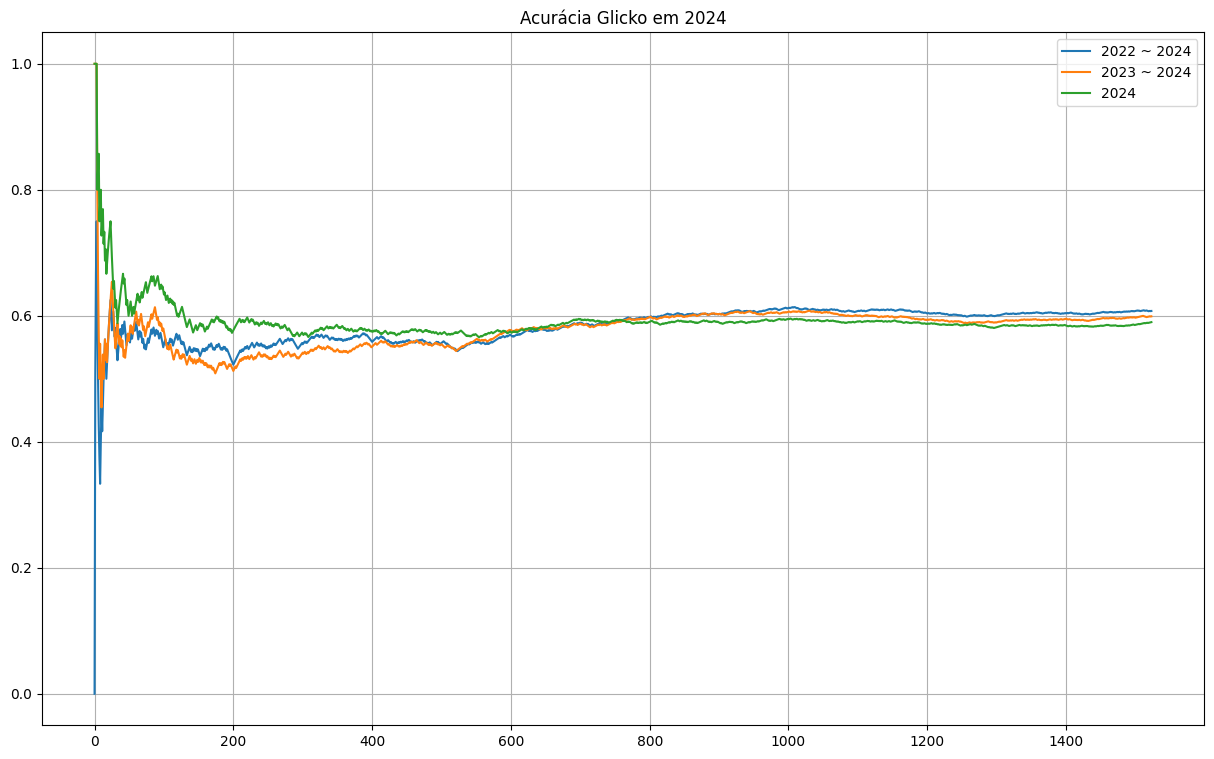

In [ ]:
acc_22_24 = get_accuracy(matches_24)
acc_23_24 = get_accuracy(X_2_24)

plt.figure(figsize=(15, 9))
plt.plot(acc_22_24['glicko_accuracy'], label='2022 ~ 2024')

plt.plot(acc_23_24['glicko_accuracy'], label='2023 ~ 2024')
plt.plot(glicko_accuracy_24['glicko_accuracy'], label='2024')
plt.title("Acurácia Glicko em 2024")
plt.grid(True)
plt.legend()

#### Gráficos Glicko Players

#### ACC players

In [ ]:
def player_acc(matches):
  dtype = np.dtype([('player_accuracy', float), ('date_time', object)])

  player_accuracy = np.zeros((len(matches), ), dtype=dtype)
  for i in range(1, len(matches)+ 1):
    initial = 0
    player_accuracy[i-1]['player_accuracy'] = ((matches.iloc[initial:i]['player_rating_diff'] > 0) == matches.iloc[initial:i]['win']).mean()
    player_accuracy[i-1]['date_time'] = matches.iloc[i-1]['date']
  return player_accuracy

In [ ]:
player_accuracy = player_acc(matches) # todas as partidas
player_accuracy_2 = player_acc(X_2)  # partidas 2023 + 2024
player_accuracy_24 = player_acc(X_24) # partidas 2024

print(f"2022 ~ 2024: {player_accuracy[-1][0]}")
print(f"2023 ~ 2024: {player_accuracy_2[-1][0]}")
print(f"2024: {player_accuracy_24[-1][0]}")

2022 ~ 2024: 0.6126069052898321
2023 ~ 2024: 0.6138107416879796
2024: 0.5918635170603674


#### Gráfico por mes players

##### Função

In [ ]:
def graph_player_accuracy(matches):

  matches_copy = matches.copy()
  matches_copy.set_index('date', inplace=True)

  # Calcule a média dos valores de 'data' por mês
  monthly_data = matches_copy.resample('M').apply(lambda x: ((x['player_rating_diff'] > 0) == x['win']).mean())
  monthly_counts = matches_copy.resample('M').size()

  # Plotando os dados
  plt.figure(figsize=(10, 6))
  plt.plot(monthly_data.index, monthly_data, marker='o', linestyle='-', zorder=1)
  plt.scatter(monthly_data.index, monthly_data, s=monthly_counts, alpha=1, c='darkorange', zorder=2)
  plt.title('Glicko accuracy by month')
  plt.xlabel('Month')
  plt.ylabel('Glicko accuracy')
  plt.grid(True)

  # Adicionando anotações com o número do mês acima de cada ponto
  for i, (date, value) in enumerate(monthly_data.items()):
      plt.annotate(date.strftime('%m'),  # Obtendo o número do mês como string
                  (date, value),         # Posição do ponto (x, y)
                  textcoords="offset points",  # Utilizando coordenadas de offset
                  xytext=(0, 10),        # Offset em relação ao ponto (x, y) em pixels
                  ha='center',
                  fontsize=9,
                  c='red'
                  )

  plt.show()

##### 2022

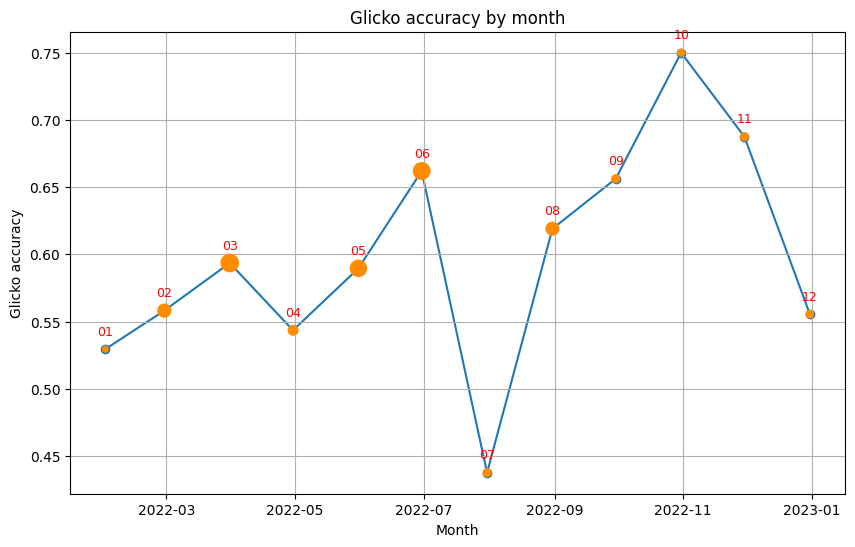

In [ ]:
graph_player_accuracy(matches_22)

##### 2023

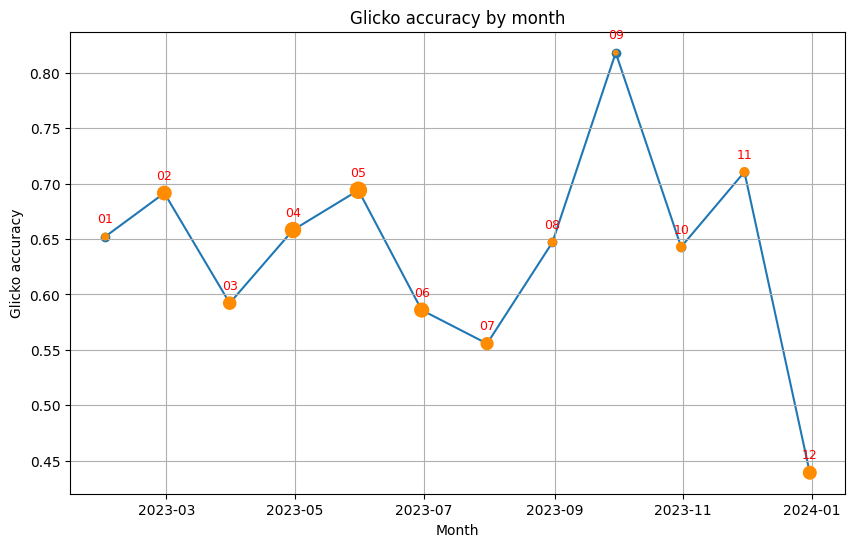

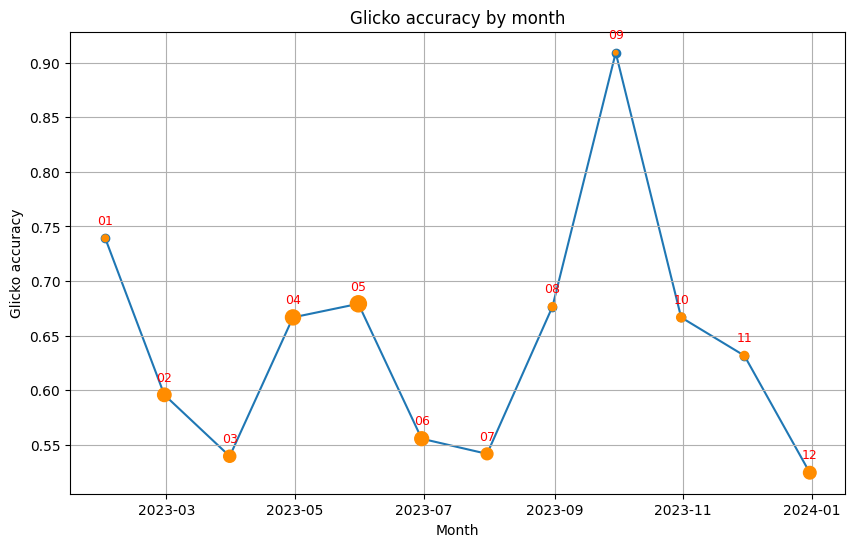

In [ ]:
graph_player_accuracy(matches_23)
graph_player_accuracy(X_2_23)

##### 2024

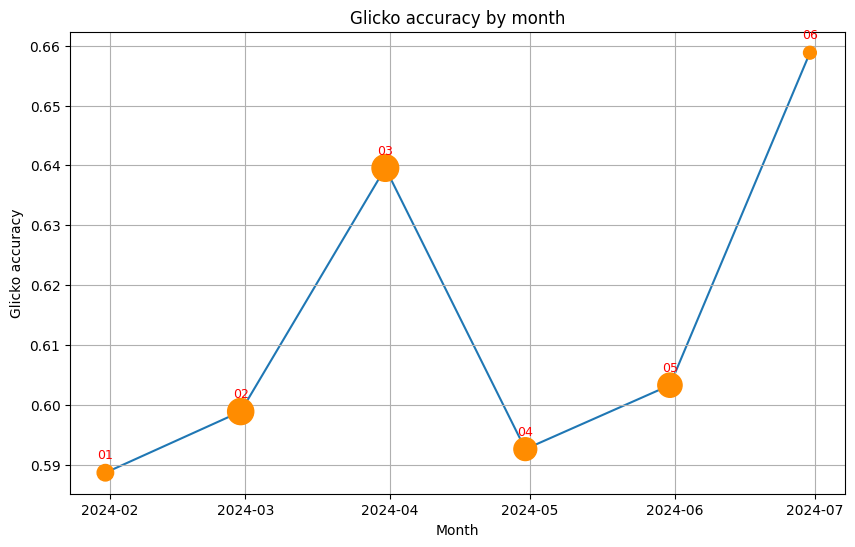

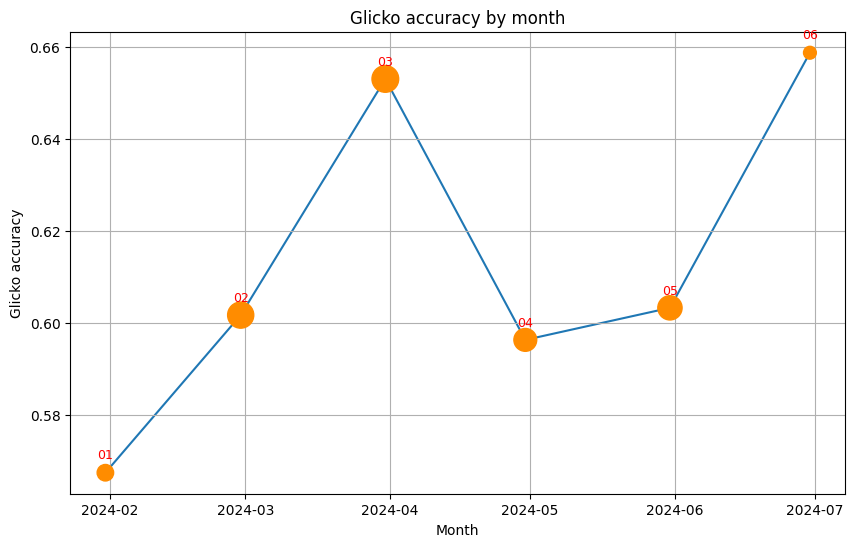

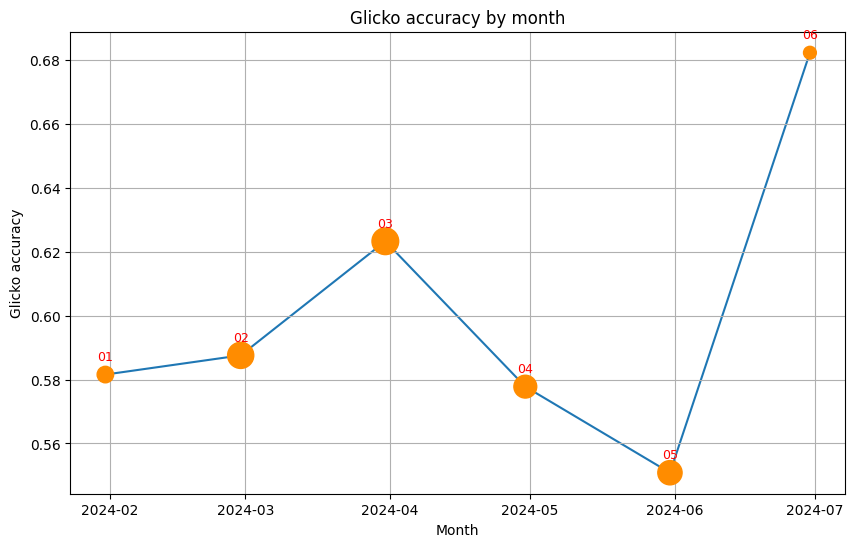

In [ ]:
graph_player_accuracy(matches_24)
graph_player_accuracy(X_2_24)
graph_player_accuracy(X_24)

#### Gráficos todos por ano

##### 2022

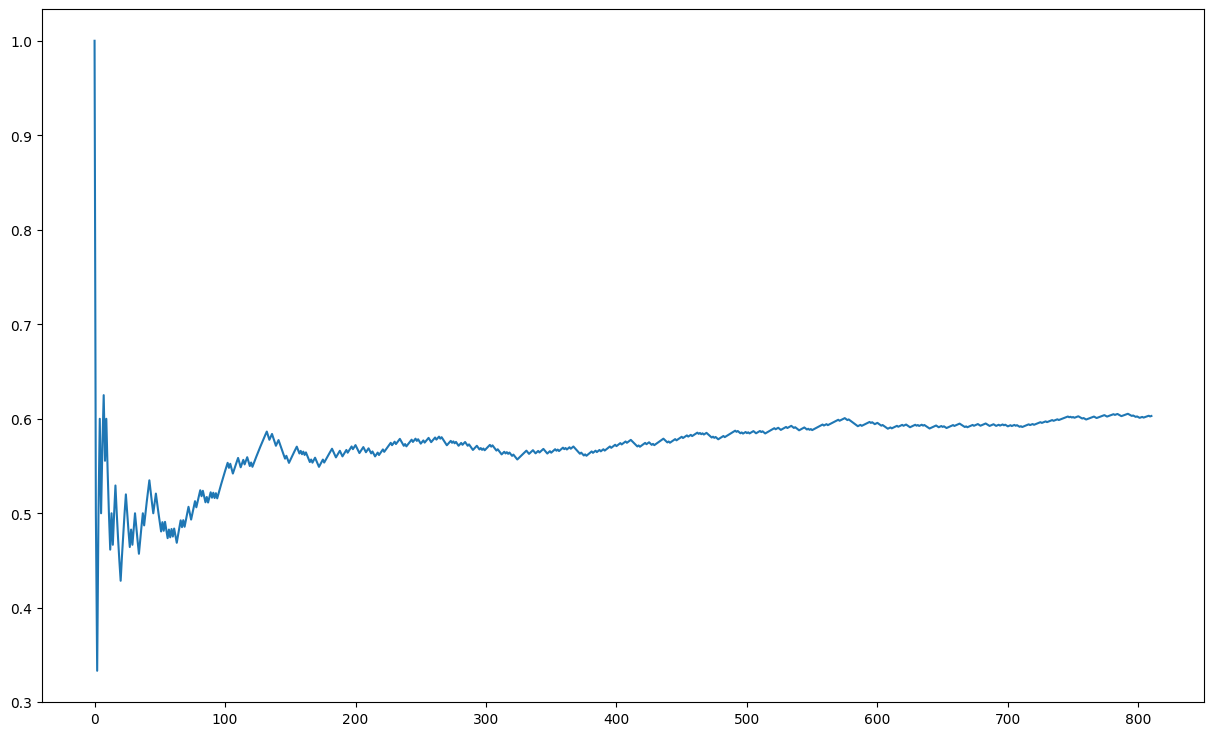

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(player_accuracy[player_accuracy['date_time'] < pd.Timestamp('2023-01-01')]['player_accuracy'], label='player Accuracy')

##### 2023

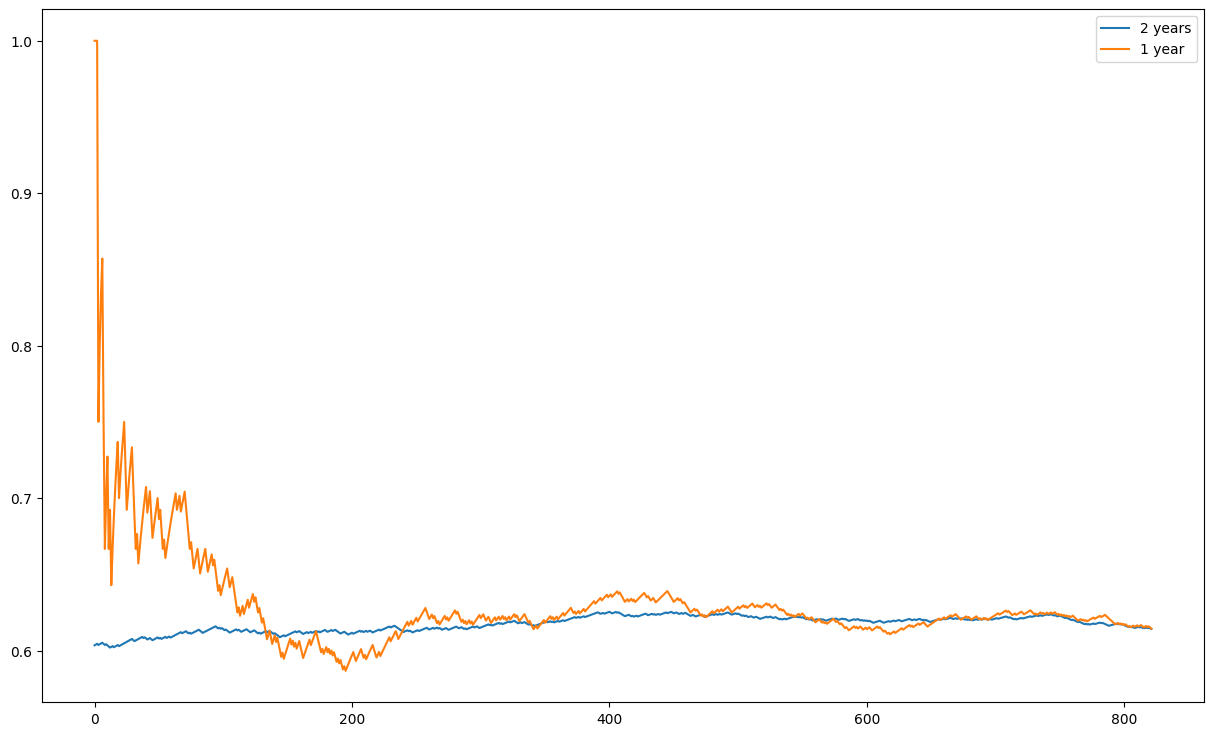

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(player_accuracy[(player_accuracy['date_time'] < pd.Timestamp('2024-01-01')) &
                         (player_accuracy['date_time'] > pd.Timestamp('2023-01-01'))]['player_accuracy'], label='2 years')
plt.plot(player_accuracy_2[(player_accuracy_2['date_time'] < pd.Timestamp('2024-01-01')) &
                         (player_accuracy_2['date_time'] > pd.Timestamp('2023-01-01'))]['player_accuracy'], label='1 year')
plt.legend()

##### 2024

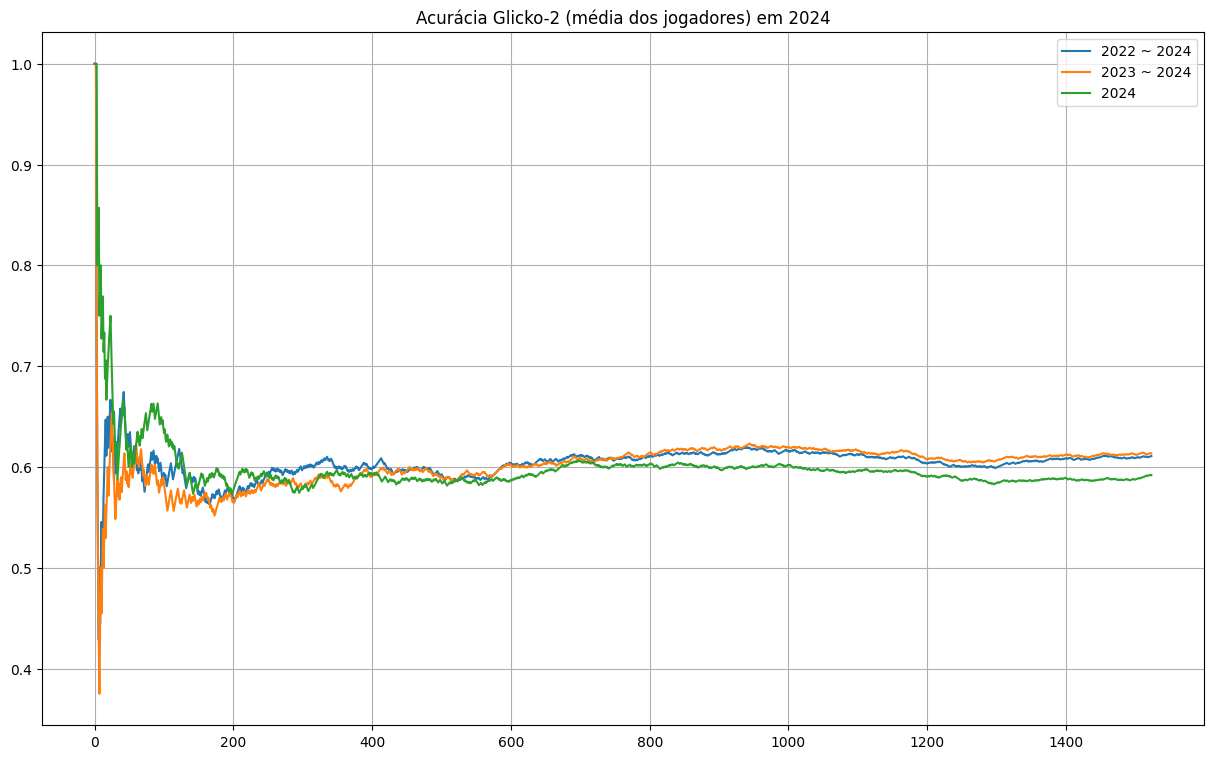

In [ ]:
player_acc_22_24 = player_acc(matches_24)
player_acc_23_24 = player_acc(X_2_24)


plt.figure(figsize=(15, 9))
plt.plot(player_acc_22_24['player_accuracy'], label='2022 ~ 2024')

plt.plot(player_acc_23_24['player_accuracy'], label='2023 ~ 2024')
plt.plot(player_accuracy_24['player_accuracy'], label='2024')

plt.title("Acurácia Glicko-2 (média dos jogadores) em 2024")
plt.grid(True)
plt.legend()

# Treino teste

### Selecionando

In [ ]:
def select_data(matches):
  X = matches.drop(columns= ['match_id', 'date', 'tournament', 'team_A', 'team_B',
       'A_score', 'B_score', 'team_A_player_1', 'team_A_player_2',
       'team_A_player_3', 'team_A_player_4', 'team_A_player_5',
       'team_B_player_1', 'team_B_player_2', 'team_B_player_3',
       'team_B_player_4', 'team_B_player_5', 'team_B_rating',
       'team_B_RD', 'team_B_sigma', 'team_A_rating', 'team_A_RD',
       'team_A_sigma', 'team_A_player_1_rating', 'team_A_player_1_RD',
       'team_A_player_1_sigma', 'team_B_player_1_rating', 'team_B_player_1_RD',
       'team_B_player_1_sigma', 'team_A_player_2_rating', 'team_A_player_2_RD',
       'team_A_player_2_sigma', 'team_B_player_2_rating', 'team_B_player_2_RD',
       'team_B_player_2_sigma', 'team_A_player_3_rating', 'team_A_player_3_RD',
       'team_A_player_3_sigma', 'team_B_player_3_rating', 'team_B_player_3_RD',
       'team_B_player_3_sigma', 'team_A_player_4_rating', 'team_A_player_4_RD',
       'team_A_player_4_sigma', 'team_B_player_4_rating', 'team_B_player_4_RD',
       'team_B_player_4_sigma', 'team_A_player_5_rating', 'team_A_player_5_RD',
       'team_A_player_5_sigma', 'team_B_player_5_rating', 'team_B_player_5_RD',
       'team_B_player_5_sigma']).copy().dropna()

  y = X.pop('win')
  return X,y

### Encoding

In [ ]:
def encode_X(X):
  categorical = X.select_dtypes(include='object').columns
  encoder = OrdinalEncoder()
  X[categorical] = encoder.fit_transform(X[categorical])
  return X, encoder

### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def scale_X(X):
  numerical = categorical = X.select_dtypes(include=['float64', 'int64']).columns
  scaler = MinMaxScaler()
  X[numerical] = scaler.fit_transform(X)
  return X, scaler

### Grid Search

In [ ]:
from sklearn.model_selection import KFold

Kfold = KFold(n_splits=5, shuffle = False)

##### SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
def svc_grid(X,y):
  SVC_model = SVC()

  SVC_model_param_grid = {'C': [1.75, 2, 2.25], 'gamma': [1] }

  SVC_model_grid = GridSearchCV(SVC_model, SVC_model_param_grid, refit=True, verbose=1, cv=Kfold)

  SVC_model_grid.fit(X, y)

  print(SVC_model_grid.best_params_)

  print(SVC_model_grid.best_score_)
  return SVC_model_grid


##### Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
def RF_grid(X,y):
  RF_model = RandomForestClassifier()

  RF_model_param_grid = {'n_estimators': [1500, 2000], 'criterion': ['gini'], 'max_features': ['sqrt'], 'max_depth' : [4] }

  RF_model_grid = GridSearchCV(RF_model, RF_model_param_grid, refit=True, verbose=1, cv=5)

  RF_model_grid.fit(X, y)

  print(RF_model_grid.best_params_)

  print(RF_model_grid.best_score_)
  return RF_model_grid

##### Ridge

In [235]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
def ridge_grid(X,y):
  Ridge_model = RidgeClassifier()

  param_grid = {'alpha': [1, 1.215, 1.5, 2], 'fit_intercept': [True, False]}

  Ridge_model_grid = GridSearchCV(Ridge_model, param_grid, refit=True, verbose=1, cv=5)

  Ridge_model_grid.fit(X, y)

  print(Ridge_model_grid.best_params_)

  print(Ridge_model_grid.best_score_ )
  return Ridge_model_grid

##### XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
def XGB_grid(X,y):
  XGB_model = XGBClassifier()

  param_grid = {
      'n_estimators': [100, 200, 500],
      'learning_rate': [0.01, 0.05],
      'max_depth': [3, 4],
      'colsample_bytree': [0.3, 0.7],
      'gamma': [0.0, 0.1, 0.2]
  }

  XGB_model_grid = GridSearchCV(XGB_model, param_grid, refit=True, verbose=1, cv=5)

  XGB_model_grid.fit(X, y)

  print(XGB_model_grid.best_params_)

  print(XGB_model_grid.best_score_)
  return XGB_model_grid

##### KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
def KNN_grid(X,y):
  KNN_model = KNeighborsClassifier()

  param_grid = {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

  KNN_model_grid = GridSearchCV(KNN_model, param_grid, refit=True, verbose=1, cv=5)

  KNN_model_grid.fit(X, y)

  print(KNN_model_grid.best_params_)

  print(KNN_model_grid.best_score_)
  return KNN_model_grid

### Executando

In [236]:
X, y = select_data(X_2)
X, encoder = encode_X(X)
X, scaler = scale_X(X)
print("SVC:")
svc_1 = svc_grid(X,y)
print("RF:")
RF_1 = RF_grid(X,y)
print("XGB:")
XGB_1 = XGB_grid(X,y)
print("RIDGE:")
ridge_1 = ridge_grid(X,y)
print("KNN:")
KNN_1 = KNN_grid(X,y)

SVC:
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'C': 1.75, 'gamma': 1}
0.575875334573334
RF:
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 2000}
0.6146540851971147
XGB:
Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.6099786780383795
RIDGE:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'alpha': 1, 'fit_intercept': True}
0.6184974821938937
KNN:
Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'metric': 'euclidean', 'n_neighbors': 28, 'weights': 'uniform'}
0.5873891938483873


### Salvando modelo

In [ ]:
import pickle

teams_2.to_parquet('teams.parquet', index=False)
players_2.to_parquet('players.parquet', index=False)
teams_24.to_parquet('teams24.parquet', index=False)
X_2.to_parquet('matches.parquet', index=False)

with open('model.pkl', 'wb') as m:
    pickle.dump(ridge_1, m)

with open('scaler.pkl', 'wb') as s:
    pickle.dump(scaler, s)

with open('encoder.pkl', 'wb') as e:
    pickle.dump(encoder, e)